# QKeras RNN comparison


# To Run Everytime

## Imports

In [2]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import nnlar
from nnlar.datashaper import DataShaper

2022-05-09 16:13:30.828597: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-09 16:13:30.836746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 16:13:30.836765: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [3]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Data creation 

In [4]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [5]:
boosted_model =  tf.keras.models.load_model('pb_file')

boosted_model.summary()


2022-05-09 16:13:43.193431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-09 16:13:43.193463: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 16:13:43.193484: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-05-09 16:13:43.193842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [6]:
# settings of the networks 
output = 1
integer = 3
def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+2)*2

def bit_width(i): return {'bits': (i+2)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 5

nbr_qepoch = 4

nbr_epoch = 500

def units(j): return (j+1)*2
units_range = 1


# path
def models_path(i) : return f"models_epoch={nbr_epoch}/models<{i},.h5"
def qmodels_path (i) : return f"qmodels_epoch=4/qmodels_units,<{bit_lenghts(i)},{integer}>.h5"

# Training

## Classic network

In [13]:
def normal_model (units_parameter):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)

    r_model = Sequential()
    r_model.add(SimpleRNN(units_parameter, input_shape=(5, 1), return_sequences=False, name='SimpleRNN'))
    r_model.add(Dense(output, activation='relu',name='dense'))
    r_model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))


    r_model.summary()

    r_model.fit(x,y,validation_data=(x_val,y_val), epochs=nbr_epoch, batch_size=20, shuffle=True, callbacks=[early_stopping, reduce_lr])


    return r_model

def model_training (): 
    models =[]
    for j in range(units_range):
        units_parameter = units (j)
        model = normal_model(units_parameter)
        models.append(model)
        model.save(models_path(i))
        print('number of units ', units_parameter)        
    return models

models = model_training()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN (SimpleRNN)       (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
45000/45000 [==============================] - 92s 2ms/step - loss: 8.7409e-04 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 2/500
45000/45000 [==============================] - 94s 2ms/step - loss: 8.7360e-04 - val_loss: 8.6983e-04 - lr: 0.0010
Epoch 3/500
25991/45000 [================>.............] - ETA: 36s - loss: 8.7011e-04

## Quantized network

In [7]:
def quantized_model (bits, original_weights):  

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)  
    qr_model = Sequential()

    qr_model.add(QSimpleRNN(8,
                        input_dim= 1,
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        recurrent_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)    
                        ))
       
    qr_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits) ))

    qr_model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    
    qr_model.summary()
    
    #using the weight from the classic network as a base
    qr_model.set_weights(original_weights.get_weights())
    qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_qepoch, callbacks=[early_stopping, reduce_lr])

    return qr_model

def qmodel_training (): 
    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        qmodel = quantized_model(bits_parameter, boosted_model)
        qmodel.save(qmodels_path(i))
        qmodels.append(qmodel)
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_training()
        

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn (QSimpleRNN)   (None, 8)                 80        
                                                                 
 q_dense (QDense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4


/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28125/28125 [==============================] - 62s 2ms/step - loss: 0.0013 - val_loss: 7.4699e-04 - lr: 1.0000e-04
Epoch 2/4
28125/28125 [==============================] - 64s 2ms/step - loss: 0.0019 - val_loss: 1.1037e-04 - lr: 1.0000e-04
Epoch 3/4
28125/28125 [==============================] - 62s 2ms/step - loss: 0.0016 - val_loss: 6.6883e-04 - lr: 1.0000e-04
Epoch 4/4
28125/28125 [==============================] - 57s 2ms/step - loss: 0.0020 - val_loss: 4.0546e-05 - lr: 1.0000e-04
bit width  {'bits': 4, 'integer': 3, 'symmetric': 0, 'alpha': 1}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_1 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_1 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable 

31250/31250 [==============================] - 38s 1ms/step


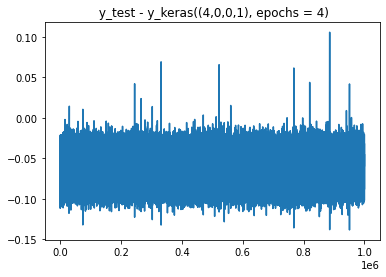

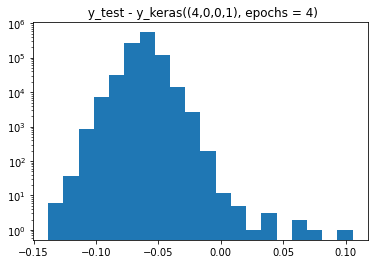

31250/31250 [==============================] - 36s 1ms/step


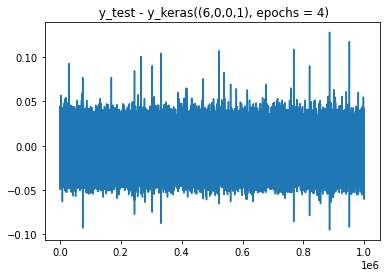

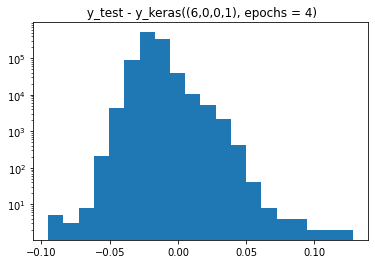

31250/31250 [==============================] - 35s 1ms/step


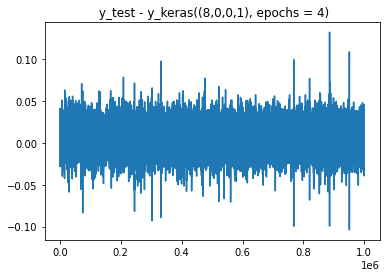

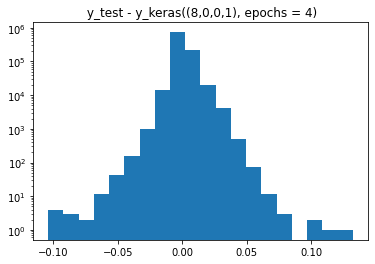

31250/31250 [==============================] - 34s 1ms/step


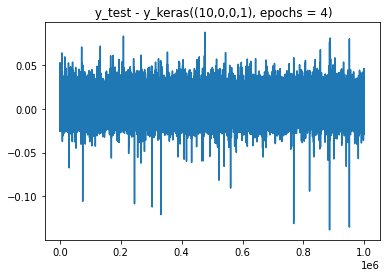

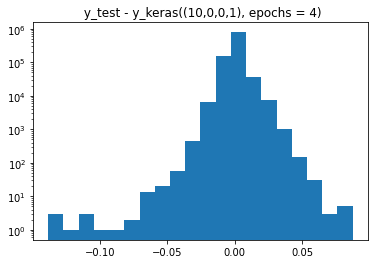

31250/31250 [==============================] - 34s 1ms/step


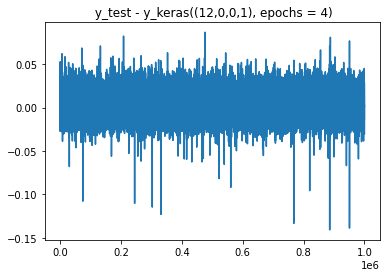

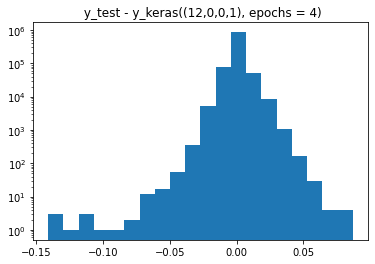

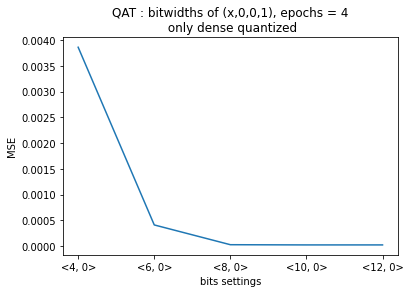

In [28]:
loss = []
bits_nbr = []
for i in range(bits_range):
    qmodel = qkeras.utils.load_qmodel(qmodels_path(i))
    y_keras = qmodel.predict(x_test)
    loss.append(mse(y_test,y_keras))
    bits_nbr.append(bit_lenghts(i))
    plt.figure()
    plt.plot(y_test - y_keras)
    plt.title(f' y_test - y_keras(({bit_lenghts(i)},{integer},0,1), epochs = {nbr_qepoch})')
    plt.show()
    plt.figure()
    plt.hist(y_test-y_keras, bins=20)
    plt.yscale('log')
    plt.title(f' y_test - y_keras(({bit_lenghts(i)},{integer},0,1), epochs = {nbr_qepoch})')
    plt.show()
    

plt.figure()
plt.plot(loss)
plt.xticks(np.arange(len(bits_nbr)), [f"<{bits}, {integer}>" for bits in bits_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'QAT : bitwidths of (x,{integer},0,1), epochs = {nbr_qepoch}\n only dense quantized')
plt.show()